In [23]:
import pandas as pd
import csv
import os
import numpy as np
import glob
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.ticker as plticker

# Unificação dos outputs dos experimentos

In [2]:
#Vamos unificar todos os dataframes de resultados encontrados no path
def get_files(path, base, extension):
    """
    Descrição: Recebe um path e lista todos os arquivos e seta o extrator + tipo de augmentation
    Retorna um dataframe com todos os files concatenados de um determinado path
    """
    all_filenames = []
    df = pd.DataFrame()
    df_interno = pd.DataFrame()
    all_filenames = [i for i in glob.glob(path+'predicts-{}*.{}'.format(base, extension))]
    
    if(len(all_filenames) > 0):
        
        for f in all_filenames:
            
            #O nome do arquivo seguiu um padrão para ser gerado, por isso podemos aproveitar algumas infos
            df_interno = pd.read_csv(f, sep=";", index_col=None, usecols=['video_name', 'frame', 'aus'])
            
            extractor = f.split("s-")[-1].split('_')[0]
            df_interno['extractor'] = extractor
            
            if(extractor == 'mediapipe'):
                var_mp = f.split('_crop')[0].split("mediapipe_")[-1]
            elif(extractor == 'dlib'):
                var_mp = 'Não se aplica'
            df_interno['var_mp'] = var_mp
            
            crop = f.split("crop_")[-1].split('_')[0]
            df_interno['crop'] = crop
            
            factor = f.split("factor_")[-1].split('_')[0].replace('.csv', '')
            df_interno['factor'] = factor
            
            experiment = f.split("s-")[-1].replace('.csv', '')
            df_interno['experiment'] = experiment
            
            print(f.split("s-")[-1].replace('.csv', ''))

            df = pd.concat([df, df_interno], axis=0)
            
        return df


In [3]:
#Carregando o arquivo de ground truth
gd_truth = '../data/outputs/Videos-Emely-Extra/predicts_squeezenet/Videos-Emely-Extra-ground-truth.csv'
DF_GROUND_TRUTH = pd.read_csv(gd_truth, sep=";", index_col=None, usecols=['video_name', 'frame', 'ground truth'])
DF_GROUND_TRUTH.head(5)

,video_name,frame,ground truth
0,VID-20190313-WA0005,1,0
1,VID-20190313-WA0005,2,0
2,VID-20190313-WA0005,3,0
3,VID-20190313-WA0005,4,0
4,VID-20190313-WA0005,5,0


In [4]:
DF_GROUND_TRUTH['total_aus'] = DF_GROUND_TRUTH['ground truth'].str.split('+').str.len()
DF_GROUND_TRUTH['total_aus'].mean()

3.1396396396396398

In [5]:
path = '../data/outputs/Videos-Emely-Extra/predicts_squeezenet/'
base = 'Videos-Emely-Extra'
extension = 'csv'

df = get_files(path, base, extension)
df.shape

dlib_crop_True_factor_101
mediapipe_posicao_crop_True_factor_0
dlib_crop_False_factor_101
mediapipe_id_crop_True_factor_0025
mediapipe_id_crop_True_factor_005
mediapipe_id_crop_False_factor_0
mediapipe_posicao_crop_True_factor_005
dlib_crop_True_factor_115
dlib_crop_False_factor_115
mediapipe_id_crop_True_factor_0
mediapipe_posicao_crop_False_factor_0
mediapipe_posicao_crop_True_factor_0025


(8016, 8)

In [6]:
df[['extractor', 'var_mp', 'crop', 'factor']].value_counts()

extractor  var_mp         crop   factor
dlib       Não se aplica  False  101       668
                                 115       668
                          True   101       668
                                 115       668
mediapipe  id             False  0         668
                          True   0         668
                                 0025      668
                                 005       668
           posicao        False  0         668
                          True   0         668
                                 0025      668
                                 005       668
dtype: int64

In [7]:
df.head(5)

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment
0,VID-20190313-WA0005,1,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101
1,VID-20190313-WA0005,2,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101
2,VID-20190313-WA0005,3,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101
3,VID-20190313-WA0005,4,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101
4,VID-20190313-WA0005,5,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101


In [8]:
#Lista de unidades de ação passada por Emely
LABELS = [
    '0', '1', '2', '4', '5', '6', '7', '8', '9', 
    '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
    '20', '21', '22', '23', '24', '25', '26', '27', '28', 
    '31', '32', '33', '34', '35', '36', '37', 
    '41', '42', '43', '44', '45', '46', 
    '50', '51', '52', '53', '54', '55', '56', '57', '58', 
    '61', '62', '63', '64', 
    '70', '71', '72', '73', 
    '81'
]
print(len(LABELS))

59


In [9]:
#Para cada frame, faça a busca do gound truth das unidades de ação
def get_ground_truth(video_name, frame):
    au_ground_truth = DF_GROUND_TRUTH.loc[(DF_GROUND_TRUTH['video_name']==video_name)
                                         & (DF_GROUND_TRUTH['frame']==frame)]
    print(au_ground_truth)
    if(len(au_ground_truth)==0):
        return '0'
    return au_ground_truth['ground truth'].item()


df['y_true'] = df.apply(lambda x: get_ground_truth(x.video_name, x.frame), axis=1)

            video_name  frame ground truth  total_aus
0  VID-20190313-WA0005      1            0          1
            video_name  frame ground truth  total_aus
1  VID-20190313-WA0005      2            0          1
            video_name  frame ground truth  total_aus
2  VID-20190313-WA0005      3            0          1
            video_name  frame ground truth  total_aus
3  VID-20190313-WA0005      4            0          1
            video_name  frame ground truth  total_aus
4  VID-20190313-WA0005      5            0          1
            video_name  frame ground truth  total_aus
5  VID-20190313-WA0005      6            0          1
            video_name  frame ground truth  total_aus
6  VID-20190313-WA0005      7            0          1
            video_name  frame ground truth  total_aus
7  VID-20190313-WA0005      8          1+2          2
            video_name  frame ground truth  total_aus
8  VID-20190313-WA0005      9          1+2          2
            video_name  fram

              video_name  frame ground truth  total_aus
125  VID-20190313-WA0005    126       1+2+28          3
              video_name  frame ground truth  total_aus
126  VID-20190313-WA0005    127       1+2+28          3
              video_name  frame ground truth  total_aus
127  VID-20190313-WA0005    128       1+2+24          3
              video_name  frame ground truth  total_aus
128  VID-20190313-WA0005    129    1+2+22+25          4
              video_name  frame ground truth  total_aus
129  VID-20190313-WA0005    130    1+2+22+25          4
              video_name  frame ground truth  total_aus
130  VID-20190313-WA0005    131    1+2+22+25          4
              video_name  frame ground truth  total_aus
131  VID-20190313-WA0005    132    1+2+22+25          4
              video_name  frame ground truth  total_aus
132  VID-20190313-WA0005    133    1+2+23+54          4
              video_name  frame ground truth  total_aus
133  VID-20190313-WA0005    134    1+2+23+54    

200  VID-20190313-WA0004     50            1          1
              video_name  frame ground truth  total_aus
201  VID-20190313-WA0004     51            1          1
              video_name  frame ground truth  total_aus
202  VID-20190313-WA0004     52         1+17          2
              video_name  frame ground truth  total_aus
203  VID-20190313-WA0004     53         1+17          2
              video_name  frame ground truth  total_aus
204  VID-20190313-WA0004     54         1+17          2
              video_name  frame ground truth  total_aus
205  VID-20190313-WA0004     55      1+15+17          3
              video_name  frame ground truth  total_aus
206  VID-20190313-WA0004     56      1+15+17          3
              video_name  frame ground truth  total_aus
207  VID-20190313-WA0004     57      1+15+17          3
              video_name  frame ground truth  total_aus
208  VID-20190313-WA0004     58      1+15+17          3
              video_name  frame ground truth  to

333  VID-20190313-WA0004    183      4+15+17          3
              video_name  frame ground truth  total_aus
334  VID-20190313-WA0004    184      4+15+17          3
              video_name  frame ground truth  total_aus
335  VID-20190313-WA0004    185      4+15+17          3
              video_name  frame ground truth  total_aus
336  VID-20190313-WA0004    186      4+15+17          3
              video_name  frame ground truth  total_aus
337  VID-20190313-WA0004    187      4+15+17          3
              video_name  frame ground truth  total_aus
338  VID-20190313-WA0004    188      4+15+17          3
              video_name  frame ground truth  total_aus
339  VID-20190313-WA0004    189      4+15+17          3
              video_name  frame ground truth  total_aus
340  VID-20190313-WA0004    190      4+15+17          3
              video_name  frame ground truth  total_aus
341  VID-20190313-WA0004    191      4+15+17          3
              video_name  frame ground truth  to

412  VID-20190313-WA0003     29  1+2+5+25+26+51          6
              video_name  frame ground truth  total_aus
413  VID-20190313-WA0003     30       1+2+51          3
              video_name  frame ground truth  total_aus
414  VID-20190313-WA0003     31       1+2+51          3
              video_name  frame ground truth  total_aus
415  VID-20190313-WA0003     32       1+2+51          3
              video_name  frame ground truth  total_aus
416  VID-20190313-WA0003     33  22+25+26+51          4
              video_name  frame ground truth  total_aus
417  VID-20190313-WA0003     34  22+25+26+51          4
              video_name  frame ground truth  total_aus
418  VID-20190313-WA0003     35  22+25+26+51          4
              video_name  frame ground truth  total_aus
419  VID-20190313-WA0003     36  22+25+26+51          4
              video_name  frame ground truth  total_aus
420  VID-20190313-WA0003     37  22+25+26+51          4
              video_name  frame ground truth 

542  VID-20190313-WA0003    159  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
543  VID-20190313-WA0003    160  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
544  VID-20190313-WA0003    161  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
545  VID-20190313-WA0003    162  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
546  VID-20190313-WA0003    163  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
547  VID-20190313-WA0003    164  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
548  VID-20190313-WA0003    165  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
549  VID-20190313-WA0003    166  1+2+12+19+25+26+52+62          8
          

632  VID-20190313-WA0003    249        12+25          2
              video_name  frame ground truth  total_aus
633  VID-20190313-WA0003    250        12+25          2
              video_name  frame ground truth  total_aus
634  VID-20190313-WA0003    251        12+25          2
              video_name  frame ground truth  total_aus
635  VID-20190313-WA0003    252        12+25          2
              video_name  frame ground truth  total_aus
636  VID-20190313-WA0003    253        12+25          2
              video_name  frame ground truth  total_aus
637  VID-20190313-WA0003    254           25          1
              video_name  frame ground truth  total_aus
638  VID-20190313-WA0003    255           25          1
              video_name  frame ground truth  total_aus
639  VID-20190313-WA0003    256            0          1
              video_name  frame ground truth  total_aus
640  VID-20190313-WA0003    257            0          1
              video_name  frame ground truth  to

91  VID-20190313-WA0005     92  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
92  VID-20190313-WA0005     93  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
93  VID-20190313-WA0005     94  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
94  VID-20190313-WA0005     95  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
95  VID-20190313-WA0005     96  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
96  VID-20190313-WA0005     97  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
97  VID-20190313-WA0005     98  4+15+19+25+26          5
             video_name  frame   ground truth  total_aus
98  VID-20190313-WA0005     99  4+15+19+25+26          5
             video_name  frame   ground truth  total_aus
99  VID-20190313-WA0005    100  4+15+19+25+26          5
              video_name  frame

178  VID-20190313-WA0004     28      1+15+55          3
              video_name  frame ground truth  total_aus
179  VID-20190313-WA0004     29      1+15+25          3
              video_name  frame ground truth  total_aus
180  VID-20190313-WA0004     30      1+15+25          3
              video_name  frame ground truth  total_aus
181  VID-20190313-WA0004     31      1+15+25          3
              video_name  frame ground truth  total_aus
182  VID-20190313-WA0004     32      1+15+25          3
              video_name  frame ground truth  total_aus
183  VID-20190313-WA0004     33      1+15+25          3
              video_name  frame ground truth  total_aus
184  VID-20190313-WA0004     34      1+15+25          3
              video_name  frame ground truth  total_aus
185  VID-20190313-WA0004     35      1+15+25          3
              video_name  frame ground truth  total_aus
186  VID-20190313-WA0004     36      1+15+25          3
              video_name  frame ground truth  to

299  VID-20190313-WA0004    149   1+15+17+55          4
              video_name  frame ground truth  total_aus
300  VID-20190313-WA0004    150   1+15+17+55          4
              video_name  frame ground truth  total_aus
301  VID-20190313-WA0004    151   1+15+17+55          4
              video_name  frame ground truth  total_aus
302  VID-20190313-WA0004    152   1+15+17+55          4
              video_name  frame ground truth  total_aus
303  VID-20190313-WA0004    153   1+15+17+55          4
              video_name  frame ground truth  total_aus
304  VID-20190313-WA0004    154   1+15+17+55          4
              video_name  frame ground truth  total_aus
305  VID-20190313-WA0004    155   1+15+17+55          4
              video_name  frame ground truth  total_aus
306  VID-20190313-WA0004    156   1+15+17+55          4
              video_name  frame ground truth  total_aus
307  VID-20190313-WA0004    157   1+15+17+55          4
              video_name  frame ground truth  to

391  VID-20190313-WA0003      8           43          1
              video_name  frame ground truth  total_aus
392  VID-20190313-WA0003      9           43          1
              video_name  frame ground truth  total_aus
393  VID-20190313-WA0003     10           43          1
              video_name  frame ground truth  total_aus
394  VID-20190313-WA0003     11           42          1
              video_name  frame ground truth  total_aus
395  VID-20190313-WA0003     12           42          1
              video_name  frame ground truth  total_aus
396  VID-20190313-WA0003     13          1+2          2
              video_name  frame ground truth  total_aus
397  VID-20190313-WA0003     14          1+2          2
              video_name  frame ground truth  total_aus
398  VID-20190313-WA0003     15          1+2          2
              video_name  frame ground truth  total_aus
399  VID-20190313-WA0003     16          1+2          2
              video_name  frame ground truth  to

503  VID-20190313-WA0003    120        12+25          2
              video_name  frame ground truth  total_aus
504  VID-20190313-WA0003    121     12+25+26          3
              video_name  frame  ground truth  total_aus
505  VID-20190313-WA0003    122  1+2+12+25+26          5
              video_name  frame  ground truth  total_aus
506  VID-20190313-WA0003    123  1+2+12+25+26          5
              video_name  frame     ground truth  total_aus
507  VID-20190313-WA0003    124  1+2+12+25+26+42          6
              video_name  frame     ground truth  total_aus
508  VID-20190313-WA0003    125  1+2+12+25+26+43          6
              video_name  frame     ground truth  total_aus
509  VID-20190313-WA0003    126  1+2+12+25+26+43          6
              video_name  frame     ground truth  total_aus
510  VID-20190313-WA0003    127  1+2+12+25+26+43          6
              video_name  frame  ground truth  total_aus
511  VID-20190313-WA0003    128  1+2+25+26+42          5
          

              video_name  frame ground truth  total_aus
575  VID-20190313-WA0003    192     12+23+62          3
              video_name  frame ground truth  total_aus
576  VID-20190313-WA0003    193     12+23+62          3
              video_name  frame ground truth  total_aus
577  VID-20190313-WA0003    194     12+23+62          3
              video_name  frame ground truth  total_aus
578  VID-20190313-WA0003    195     12+23+62          3
              video_name  frame ground truth  total_aus
579  VID-20190313-WA0003    196     12+23+62          3
              video_name  frame ground truth  total_aus
580  VID-20190313-WA0003    197  12+22+25+62          4
              video_name  frame ground truth  total_aus
581  VID-20190313-WA0003    198  12+22+25+62          4
              video_name  frame ground truth  total_aus
582  VID-20190313-WA0003    199  12+22+25+62          4
              video_name  frame ground truth  total_aus
583  VID-20190313-WA0003    200  12+22+25+42    

             video_name  frame ground truth  total_aus
44  VID-20190313-WA0005     45         4+72          2
             video_name  frame ground truth  total_aus
45  VID-20190313-WA0005     46         4+72          2
             video_name  frame ground truth  total_aus
46  VID-20190313-WA0005     47         4+72          2
             video_name  frame ground truth  total_aus
47  VID-20190313-WA0005     48         4+72          2
             video_name  frame ground truth  total_aus
48  VID-20190313-WA0005     49         4+72          2
             video_name  frame ground truth  total_aus
49  VID-20190313-WA0005     50         4+72          2
             video_name  frame ground truth  total_aus
50  VID-20190313-WA0005     51         4+72          2
             video_name  frame ground truth  total_aus
51  VID-20190313-WA0005     52         4+72          2
             video_name  frame ground truth  total_aus
52  VID-20190313-WA0005     53         4+72          2
          

              video_name  frame     ground truth  total_aus
117  VID-20190313-WA0005    118  1+2+25+26+42+52          6
              video_name  frame ground truth  total_aus
118  VID-20190313-WA0005    119    1+2+28+51          4
              video_name  frame ground truth  total_aus
119  VID-20190313-WA0005    120    1+2+28+51          4
              video_name  frame ground truth  total_aus
120  VID-20190313-WA0005    121    1+2+28+51          4
              video_name  frame ground truth  total_aus
121  VID-20190313-WA0005    122    1+2+28+51          4
              video_name  frame ground truth  total_aus
122  VID-20190313-WA0005    123    1+2+28+51          4
              video_name  frame ground truth  total_aus
123  VID-20190313-WA0005    124    1+2+28+51          4
              video_name  frame ground truth  total_aus
124  VID-20190313-WA0005    125    1+2+28+51          4
              video_name  frame ground truth  total_aus
125  VID-20190313-WA0005    126       1+

256  VID-20190313-WA0004    106   1+15+25+26          4
              video_name  frame ground truth  total_aus
257  VID-20190313-WA0004    107   1+15+25+26          4
              video_name  frame ground truth  total_aus
258  VID-20190313-WA0004    108   1+15+25+26          4
              video_name  frame ground truth  total_aus
259  VID-20190313-WA0004    109   1+15+25+26          4
              video_name  frame ground truth  total_aus
260  VID-20190313-WA0004    110   1+15+25+26          4
              video_name  frame ground truth  total_aus
261  VID-20190313-WA0004    111   1+15+25+26          4
              video_name  frame ground truth  total_aus
262  VID-20190313-WA0004    112   1+15+25+26          4
              video_name  frame ground truth  total_aus
263  VID-20190313-WA0004    113   1+15+25+26          4
              video_name  frame ground truth  total_aus
264  VID-20190313-WA0004    114   1+15+25+26          4
              video_name  frame ground truth  to

347  VID-20190313-WA0004    197      4+15+17          3
              video_name  frame ground truth  total_aus
348  VID-20190313-WA0004    198      4+15+17          3
              video_name  frame ground truth  total_aus
349  VID-20190313-WA0004    199      4+15+17          3
              video_name  frame ground truth  total_aus
350  VID-20190313-WA0004    200      4+15+17          3
              video_name  frame ground truth  total_aus
351  VID-20190313-WA0004    201      4+15+17          3
              video_name  frame ground truth  total_aus
352  VID-20190313-WA0004    202      4+15+17          3
              video_name  frame ground truth  total_aus
353  VID-20190313-WA0004    203      4+15+17          3
              video_name  frame ground truth  total_aus
354  VID-20190313-WA0004    204      4+15+17          3
              video_name  frame ground truth  total_aus
355  VID-20190313-WA0004    205      4+15+17          3
              video_name  frame ground truth  to

463  VID-20190313-WA0003     80     12+25+44          3
              video_name  frame    ground truth  total_aus
464  VID-20190313-WA0003     81  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
465  VID-20190313-WA0003     82  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
466  VID-20190313-WA0003     83  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
467  VID-20190313-WA0003     84  12+25+26+44+52          5
              video_name  frame ground truth  total_aus
468  VID-20190313-WA0003     85     12+25+52          3
              video_name  frame ground truth  total_aus
469  VID-20190313-WA0003     86     12+25+52          3
              video_name  frame ground truth  total_aus
470  VID-20190313-WA0003     87     12+25+52          3
              video_name  frame ground truth  total_aus
471  VID-20190313-WA0003     88     12+25+52          3
              video_name

536  VID-20190313-WA0003    153  1+2+19+25+26+52+62          7
              video_name  frame        ground truth  total_aus
537  VID-20190313-WA0003    154  1+2+19+25+26+52+62          7
              video_name  frame        ground truth  total_aus
538  VID-20190313-WA0003    155  1+2+19+25+26+52+62          7
              video_name  frame           ground truth  total_aus
539  VID-20190313-WA0003    156  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
540  VID-20190313-WA0003    157  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
541  VID-20190313-WA0003    158  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
542  VID-20190313-WA0003    159  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
543  VID-20190313-WA0003    160  1+2+12+19+25+26+52+62          8
              video_name 

4  VID-20190313-WA0005      5            0          1
            video_name  frame ground truth  total_aus
5  VID-20190313-WA0005      6            0          1
            video_name  frame ground truth  total_aus
6  VID-20190313-WA0005      7            0          1
            video_name  frame ground truth  total_aus
7  VID-20190313-WA0005      8          1+2          2
            video_name  frame ground truth  total_aus
8  VID-20190313-WA0005      9          1+2          2
            video_name  frame ground truth  total_aus
9  VID-20190313-WA0005     10          1+2          2
             video_name  frame ground truth  total_aus
10  VID-20190313-WA0005     11          1+2          2
             video_name  frame ground truth  total_aus
11  VID-20190313-WA0005     12           42          1
             video_name  frame ground truth  total_aus
12  VID-20190313-WA0005     13       1+2+43          3
             video_name  frame ground truth  total_aus
13  VID-20190313-WA00

95  VID-20190313-WA0005     96  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
96  VID-20190313-WA0005     97  4+15+25+26+44          5
             video_name  frame   ground truth  total_aus
97  VID-20190313-WA0005     98  4+15+19+25+26          5
             video_name  frame   ground truth  total_aus
98  VID-20190313-WA0005     99  4+15+19+25+26          5
             video_name  frame   ground truth  total_aus
99  VID-20190313-WA0005    100  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
100  VID-20190313-WA0005    101  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
101  VID-20190313-WA0005    102  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
102  VID-20190313-WA0005    103  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
103  VID-20190313-WA0005    104  4+15+19+25+26          5
              video_nam

207  VID-20190313-WA0004     57      1+15+17          3
              video_name  frame ground truth  total_aus
208  VID-20190313-WA0004     58      1+15+17          3
              video_name  frame ground truth  total_aus
209  VID-20190313-WA0004     59      1+15+17          3
              video_name  frame ground truth  total_aus
210  VID-20190313-WA0004     60      1+15+17          3
              video_name  frame ground truth  total_aus
211  VID-20190313-WA0004     61      1+15+17          3
              video_name  frame ground truth  total_aus
212  VID-20190313-WA0004     62      1+15+17          3
              video_name  frame ground truth  total_aus
213  VID-20190313-WA0004     63      1+15+17          3
              video_name  frame ground truth  total_aus
214  VID-20190313-WA0004     64      1+15+17          3
              video_name  frame ground truth  total_aus
215  VID-20190313-WA0004     65      1+15+17          3
              video_name  frame ground truth  to

281  VID-20190313-WA0004    131      1+15+25          3
              video_name  frame ground truth  total_aus
282  VID-20190313-WA0004    132      1+15+25          3
              video_name  frame ground truth  total_aus
283  VID-20190313-WA0004    133      1+15+25          3
              video_name  frame ground truth  total_aus
284  VID-20190313-WA0004    134         1+17          2
              video_name  frame ground truth  total_aus
285  VID-20190313-WA0004    135         1+17          2
              video_name  frame ground truth  total_aus
286  VID-20190313-WA0004    136         1+17          2
              video_name  frame ground truth  total_aus
287  VID-20190313-WA0004    137         1+17          2
              video_name  frame ground truth  total_aus
288  VID-20190313-WA0004    138   1+15+25+26          4
              video_name  frame ground truth  total_aus
289  VID-20190313-WA0004    139   1+15+25+26          4
              video_name  frame ground truth  to

              video_name  frame    ground truth  total_aus
408  VID-20190313-WA0003     25  1+2+5+25+26+51          6
              video_name  frame    ground truth  total_aus
409  VID-20190313-WA0003     26  1+2+5+25+26+51          6
              video_name  frame    ground truth  total_aus
410  VID-20190313-WA0003     27  1+2+5+25+26+51          6
              video_name  frame    ground truth  total_aus
411  VID-20190313-WA0003     28  1+2+5+25+26+51          6
              video_name  frame    ground truth  total_aus
412  VID-20190313-WA0003     29  1+2+5+25+26+51          6
              video_name  frame ground truth  total_aus
413  VID-20190313-WA0003     30       1+2+51          3
              video_name  frame ground truth  total_aus
414  VID-20190313-WA0003     31       1+2+51          3
              video_name  frame ground truth  total_aus
415  VID-20190313-WA0003     32       1+2+51          3
              video_name  frame ground truth  total_aus
416  VID-20190313-

495  VID-20190313-WA0003    112        12+25          2
              video_name  frame ground truth  total_aus
496  VID-20190313-WA0003    113        12+25          2
              video_name  frame ground truth  total_aus
497  VID-20190313-WA0003    114        12+25          2
              video_name  frame ground truth  total_aus
498  VID-20190313-WA0003    115        12+25          2
              video_name  frame ground truth  total_aus
499  VID-20190313-WA0003    116        12+25          2
              video_name  frame ground truth  total_aus
500  VID-20190313-WA0003    117        12+25          2
              video_name  frame ground truth  total_aus
501  VID-20190313-WA0003    118        12+25          2
              video_name  frame ground truth  total_aus
502  VID-20190313-WA0003    119        12+25          2
              video_name  frame ground truth  total_aus
503  VID-20190313-WA0003    120        12+25          2
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
603  VID-20190313-WA0003    220        12+25          2
              video_name  frame ground truth  total_aus
604  VID-20190313-WA0003    221        12+25          2
              video_name  frame ground truth  total_aus
605  VID-20190313-WA0003    222        12+25          2
              video_name  frame ground truth  total_aus
606  VID-20190313-WA0003    223        12+25          2
              video_name  frame ground truth  total_aus
607  VID-20190313-WA0003    224        12+25          2
              video_name  frame ground truth  total_aus
608  VID-20190313-WA0003    225        12+25          2
              video_name  frame ground truth  total_aus
609  VID-20190313-WA0003    226        12+25          2
              video_name  frame ground truth  total_aus
610  VID-20190313-WA0003    227        12+25          2
              video_name  frame ground truth  total_aus
611  VID-20190313-WA0003    228        12+25    

             video_name  frame ground truth  total_aus
20  VID-20190313-WA0005     21   4+25+26+51          4
             video_name  frame ground truth  total_aus
21  VID-20190313-WA0005     22   4+25+26+51          4
             video_name  frame ground truth  total_aus
22  VID-20190313-WA0005     23   4+25+26+51          4
             video_name  frame ground truth  total_aus
23  VID-20190313-WA0005     24   4+25+26+51          4
             video_name  frame ground truth  total_aus
24  VID-20190313-WA0005     25   4+25+26+51          4
             video_name  frame ground truth  total_aus
25  VID-20190313-WA0005     26   4+25+26+51          4
             video_name  frame ground truth  total_aus
26  VID-20190313-WA0005     27   4+25+26+51          4
             video_name  frame ground truth  total_aus
27  VID-20190313-WA0005     28   4+25+26+51          4
             video_name  frame ground truth  total_aus
28  VID-20190313-WA0005     29   4+25+26+51          4
          

              video_name  frame ground truth  total_aus
138  VID-20190313-WA0005    139           54          1
              video_name  frame ground truth  total_aus
139  VID-20190313-WA0005    140           54          1
              video_name  frame ground truth  total_aus
140  VID-20190313-WA0005    141            0          1
              video_name  frame ground truth  total_aus
141  VID-20190313-WA0005    142            0          1
              video_name  frame ground truth  total_aus
142  VID-20190313-WA0005    143            0          1
              video_name  frame ground truth  total_aus
143  VID-20190313-WA0005    144            0          1
              video_name  frame ground truth  total_aus
144  VID-20190313-WA0005    145            0          1
              video_name  frame ground truth  total_aus
145  VID-20190313-WA0005    146            0          1
              video_name  frame ground truth  total_aus
146  VID-20190313-WA0005    147            0    

              video_name  frame ground truth  total_aus
226  VID-20190313-WA0004     76      1+15+17          3
              video_name  frame ground truth  total_aus
227  VID-20190313-WA0004     77      1+15+17          3
              video_name  frame ground truth  total_aus
228  VID-20190313-WA0004     78      1+15+17          3
              video_name  frame ground truth  total_aus
229  VID-20190313-WA0004     79      1+15+17          3
              video_name  frame ground truth  total_aus
230  VID-20190313-WA0004     80      1+15+17          3
              video_name  frame ground truth  total_aus
231  VID-20190313-WA0004     81      1+15+17          3
              video_name  frame ground truth  total_aus
232  VID-20190313-WA0004     82      1+15+17          3
              video_name  frame ground truth  total_aus
233  VID-20190313-WA0004     83      1+15+17          3
              video_name  frame ground truth  total_aus
234  VID-20190313-WA0004     84      1+15+17    

344  VID-20190313-WA0004    194      4+15+17          3
              video_name  frame ground truth  total_aus
345  VID-20190313-WA0004    195      4+15+17          3
              video_name  frame ground truth  total_aus
346  VID-20190313-WA0004    196      4+15+17          3
              video_name  frame ground truth  total_aus
347  VID-20190313-WA0004    197      4+15+17          3
              video_name  frame ground truth  total_aus
348  VID-20190313-WA0004    198      4+15+17          3
              video_name  frame ground truth  total_aus
349  VID-20190313-WA0004    199      4+15+17          3
              video_name  frame ground truth  total_aus
350  VID-20190313-WA0004    200      4+15+17          3
              video_name  frame ground truth  total_aus
351  VID-20190313-WA0004    201      4+15+17          3
              video_name  frame ground truth  total_aus
352  VID-20190313-WA0004    202      4+15+17          3
              video_name  frame ground truth  to

419  VID-20190313-WA0003     36  22+25+26+51          4
              video_name  frame ground truth  total_aus
420  VID-20190313-WA0003     37  22+25+26+51          4
              video_name  frame ground truth  total_aus
421  VID-20190313-WA0003     38  22+25+26+51          4
              video_name  frame ground truth  total_aus
422  VID-20190313-WA0003     39  22+25+26+51          4
              video_name  frame ground truth  total_aus
423  VID-20190313-WA0003     40  22+25+26+51          4
              video_name  frame ground truth  total_aus
424  VID-20190313-WA0003     41  22+25+26+51          4
              video_name  frame ground truth  total_aus
425  VID-20190313-WA0003     42  12+25+26+51          4
              video_name  frame ground truth  total_aus
426  VID-20190313-WA0003     43  12+25+26+51          4
              video_name  frame ground truth  total_aus
427  VID-20190313-WA0003     44  12+25+26+51          4
              video_name  frame ground truth  to

              video_name  frame           ground truth  total_aus
539  VID-20190313-WA0003    156  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
540  VID-20190313-WA0003    157  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
541  VID-20190313-WA0003    158  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
542  VID-20190313-WA0003    159  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
543  VID-20190313-WA0003    160  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
544  VID-20190313-WA0003    161  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
545  VID-20190313-WA0003    162  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
546  VID-2

623  VID-20190313-WA0003    240        12+25          2
              video_name  frame ground truth  total_aus
624  VID-20190313-WA0003    241        12+25          2
              video_name  frame ground truth  total_aus
625  VID-20190313-WA0003    242        12+25          2
              video_name  frame ground truth  total_aus
626  VID-20190313-WA0003    243        12+25          2
              video_name  frame ground truth  total_aus
627  VID-20190313-WA0003    244        12+25          2
              video_name  frame ground truth  total_aus
628  VID-20190313-WA0003    245        12+25          2
              video_name  frame ground truth  total_aus
629  VID-20190313-WA0003    246        12+25          2
              video_name  frame ground truth  total_aus
630  VID-20190313-WA0003    247        12+25          2
              video_name  frame ground truth  total_aus
631  VID-20190313-WA0003    248        12+25          2
              video_name  frame ground truth  to

             video_name  frame ground truth  total_aus
76  VID-20190313-WA0005     77         4+72          2
             video_name  frame ground truth  total_aus
77  VID-20190313-WA0005     78         4+72          2
             video_name  frame ground truth  total_aus
78  VID-20190313-WA0005     79         4+72          2
             video_name  frame ground truth  total_aus
79  VID-20190313-WA0005     80         4+72          2
             video_name  frame ground truth  total_aus
80  VID-20190313-WA0005     81         4+72          2
             video_name  frame   ground truth  total_aus
81  VID-20190313-WA0005     82  4+15+17+26+44          5
             video_name  frame   ground truth  total_aus
82  VID-20190313-WA0005     83  4+15+17+26+44          5
             video_name  frame   ground truth  total_aus
83  VID-20190313-WA0005     84  4+15+17+26+44          5
             video_name  frame   ground truth  total_aus
84  VID-20190313-WA0005     85  4+15+17+26+44      

160  VID-20190313-WA0004     10        25+26          2
              video_name  frame ground truth  total_aus
161  VID-20190313-WA0004     11        25+26          2
              video_name  frame ground truth  total_aus
162  VID-20190313-WA0004     12        25+26          2
              video_name  frame ground truth  total_aus
163  VID-20190313-WA0004     13        25+26          2
              video_name  frame ground truth  total_aus
164  VID-20190313-WA0004     14        25+26          2
              video_name  frame ground truth  total_aus
165  VID-20190313-WA0004     15        25+26          2
              video_name  frame ground truth  total_aus
166  VID-20190313-WA0004     16        25+26          2
              video_name  frame ground truth  total_aus
167  VID-20190313-WA0004     17        25+26          2
              video_name  frame ground truth  total_aus
168  VID-20190313-WA0004     18        25+26          2
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
254  VID-20190313-WA0004    104     15+25+26          3
              video_name  frame ground truth  total_aus
255  VID-20190313-WA0004    105   1+15+25+26          4
              video_name  frame ground truth  total_aus
256  VID-20190313-WA0004    106   1+15+25+26          4
              video_name  frame ground truth  total_aus
257  VID-20190313-WA0004    107   1+15+25+26          4
              video_name  frame ground truth  total_aus
258  VID-20190313-WA0004    108   1+15+25+26          4
              video_name  frame ground truth  total_aus
259  VID-20190313-WA0004    109   1+15+25+26          4
              video_name  frame ground truth  total_aus
260  VID-20190313-WA0004    110   1+15+25+26          4
              video_name  frame ground truth  total_aus
261  VID-20190313-WA0004    111   1+15+25+26          4
              video_name  frame ground truth  total_aus
262  VID-20190313-WA0004    112   1+15+25+26    

              video_name  frame ground truth  total_aus
359  VID-20190313-WA0004    209         1+17          2
              video_name  frame ground truth  total_aus
360  VID-20190313-WA0004    210         1+17          2
              video_name  frame ground truth  total_aus
361  VID-20190313-WA0004    211         1+17          2
              video_name  frame ground truth  total_aus
362  VID-20190313-WA0004    212            0          1
              video_name  frame ground truth  total_aus
363  VID-20190313-WA0004    213            0          1
              video_name  frame ground truth  total_aus
364  VID-20190313-WA0004    214            0          1
              video_name  frame ground truth  total_aus
365  VID-20190313-WA0004    215            0          1
              video_name  frame ground truth  total_aus
366  VID-20190313-WA0004    216            0          1
              video_name  frame ground truth  total_aus
367  VID-20190313-WA0004    217            0    

              video_name  frame ground truth  total_aus
469  VID-20190313-WA0003     86     12+25+52          3
              video_name  frame ground truth  total_aus
470  VID-20190313-WA0003     87     12+25+52          3
              video_name  frame ground truth  total_aus
471  VID-20190313-WA0003     88     12+25+52          3
              video_name  frame ground truth  total_aus
472  VID-20190313-WA0003     89     12+25+52          3
              video_name  frame ground truth  total_aus
473  VID-20190313-WA0003     90     12+25+52          3
              video_name  frame ground truth  total_aus
474  VID-20190313-WA0003     91     12+25+52          3
              video_name  frame ground truth  total_aus
475  VID-20190313-WA0003     92     12+25+52          3
              video_name  frame ground truth  total_aus
476  VID-20190313-WA0003     93     12+25+52          3
              video_name  frame ground truth  total_aus
477  VID-20190313-WA0003     94     12+25+52    

579  VID-20190313-WA0003    196     12+23+62          3
              video_name  frame ground truth  total_aus
580  VID-20190313-WA0003    197  12+22+25+62          4
              video_name  frame ground truth  total_aus
581  VID-20190313-WA0003    198  12+22+25+62          4
              video_name  frame ground truth  total_aus
582  VID-20190313-WA0003    199  12+22+25+62          4
              video_name  frame ground truth  total_aus
583  VID-20190313-WA0003    200  12+22+25+42          4
              video_name  frame ground truth  total_aus
584  VID-20190313-WA0003    201     12+23+43          3
              video_name  frame ground truth  total_aus
585  VID-20190313-WA0003    202     12+23+42          3
              video_name  frame ground truth  total_aus
586  VID-20190313-WA0003    203     12+23+42          3
              video_name  frame ground truth  total_aus
587  VID-20190313-WA0003    204     12+23+42          3
              video_name  frame ground truth  to

             video_name  frame ground truth  total_aus
18  VID-20190313-WA0005     19        25+26          2
             video_name  frame ground truth  total_aus
19  VID-20190313-WA0005     20   4+25+26+51          4
             video_name  frame ground truth  total_aus
20  VID-20190313-WA0005     21   4+25+26+51          4
             video_name  frame ground truth  total_aus
21  VID-20190313-WA0005     22   4+25+26+51          4
             video_name  frame ground truth  total_aus
22  VID-20190313-WA0005     23   4+25+26+51          4
             video_name  frame ground truth  total_aus
23  VID-20190313-WA0005     24   4+25+26+51          4
             video_name  frame ground truth  total_aus
24  VID-20190313-WA0005     25   4+25+26+51          4
             video_name  frame ground truth  total_aus
25  VID-20190313-WA0005     26   4+25+26+51          4
             video_name  frame ground truth  total_aus
26  VID-20190313-WA0005     27   4+25+26+51          4
          

              video_name  frame ground truth  total_aus
130  VID-20190313-WA0005    131    1+2+22+25          4
              video_name  frame ground truth  total_aus
131  VID-20190313-WA0005    132    1+2+22+25          4
              video_name  frame ground truth  total_aus
132  VID-20190313-WA0005    133    1+2+23+54          4
              video_name  frame ground truth  total_aus
133  VID-20190313-WA0005    134    1+2+23+54          4
              video_name  frame ground truth  total_aus
134  VID-20190313-WA0005    135    1+2+23+54          4
              video_name  frame ground truth  total_aus
135  VID-20190313-WA0005    136    1+2+23+54          4
              video_name  frame ground truth  total_aus
136  VID-20190313-WA0005    137    1+2+23+54          4
              video_name  frame ground truth  total_aus
137  VID-20190313-WA0005    138    1+2+23+54          4
              video_name  frame ground truth  total_aus
138  VID-20190313-WA0005    139           54    

              video_name  frame ground truth  total_aus
224  VID-20190313-WA0004     74      1+15+17          3
              video_name  frame ground truth  total_aus
225  VID-20190313-WA0004     75      1+15+17          3
              video_name  frame ground truth  total_aus
226  VID-20190313-WA0004     76      1+15+17          3
              video_name  frame ground truth  total_aus
227  VID-20190313-WA0004     77      1+15+17          3
              video_name  frame ground truth  total_aus
228  VID-20190313-WA0004     78      1+15+17          3
              video_name  frame ground truth  total_aus
229  VID-20190313-WA0004     79      1+15+17          3
              video_name  frame ground truth  total_aus
230  VID-20190313-WA0004     80      1+15+17          3
              video_name  frame ground truth  total_aus
231  VID-20190313-WA0004     81      1+15+17          3
              video_name  frame ground truth  total_aus
232  VID-20190313-WA0004     82      1+15+17    

323  VID-20190313-WA0004    173         1+17          2
              video_name  frame ground truth  total_aus
324  VID-20190313-WA0004    174         1+17          2
              video_name  frame ground truth  total_aus
325  VID-20190313-WA0004    175         1+17          2
              video_name  frame ground truth  total_aus
326  VID-20190313-WA0004    176         1+17          2
              video_name  frame ground truth  total_aus
327  VID-20190313-WA0004    177         1+17          2
              video_name  frame ground truth  total_aus
328  VID-20190313-WA0004    178         1+17          2
              video_name  frame ground truth  total_aus
329  VID-20190313-WA0004    179         1+17          2
              video_name  frame ground truth  total_aus
330  VID-20190313-WA0004    180         1+17          2
              video_name  frame ground truth  total_aus
331  VID-20190313-WA0004    181         1+17          2
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
419  VID-20190313-WA0003     36  22+25+26+51          4
              video_name  frame ground truth  total_aus
420  VID-20190313-WA0003     37  22+25+26+51          4
              video_name  frame ground truth  total_aus
421  VID-20190313-WA0003     38  22+25+26+51          4
              video_name  frame ground truth  total_aus
422  VID-20190313-WA0003     39  22+25+26+51          4
              video_name  frame ground truth  total_aus
423  VID-20190313-WA0003     40  22+25+26+51          4
              video_name  frame ground truth  total_aus
424  VID-20190313-WA0003     41  22+25+26+51          4
              video_name  frame ground truth  total_aus
425  VID-20190313-WA0003     42  12+25+26+51          4
              video_name  frame ground truth  total_aus
426  VID-20190313-WA0003     43  12+25+26+51          4
              video_name  frame ground truth  total_aus
427  VID-20190313-WA0003     44  12+25+26+51    

518  VID-20190313-WA0003    135       1+2+51          3
              video_name  frame ground truth  total_aus
519  VID-20190313-WA0003    136       1+2+51          3
              video_name  frame ground truth  total_aus
520  VID-20190313-WA0003    137       1+2+51          3
              video_name  frame ground truth  total_aus
521  VID-20190313-WA0003    138          1+2          2
              video_name  frame ground truth  total_aus
522  VID-20190313-WA0003    139          1+2          2
              video_name  frame ground truth  total_aus
523  VID-20190313-WA0003    140          1+2          2
              video_name  frame ground truth  total_aus
524  VID-20190313-WA0003    141          1+2          2
              video_name  frame ground truth  total_aus
525  VID-20190313-WA0003    142          1+2          2
              video_name  frame ground truth  total_aus
526  VID-20190313-WA0003    143          1+2          2
              video_name  frame ground truth  to

620  VID-20190313-WA0003    237        12+25          2
              video_name  frame ground truth  total_aus
621  VID-20190313-WA0003    238        12+25          2
              video_name  frame ground truth  total_aus
622  VID-20190313-WA0003    239        12+25          2
              video_name  frame ground truth  total_aus
623  VID-20190313-WA0003    240        12+25          2
              video_name  frame ground truth  total_aus
624  VID-20190313-WA0003    241        12+25          2
              video_name  frame ground truth  total_aus
625  VID-20190313-WA0003    242        12+25          2
              video_name  frame ground truth  total_aus
626  VID-20190313-WA0003    243        12+25          2
              video_name  frame ground truth  total_aus
627  VID-20190313-WA0003    244        12+25          2
              video_name  frame ground truth  total_aus
628  VID-20190313-WA0003    245        12+25          2
              video_name  frame ground truth  to

61  VID-20190313-WA0005     62         4+72          2
             video_name  frame   ground truth  total_aus
62  VID-20190313-WA0005     63  4+15+25+26+51          5
             video_name  frame   ground truth  total_aus
63  VID-20190313-WA0005     64  4+15+25+26+51          5
             video_name  frame   ground truth  total_aus
64  VID-20190313-WA0005     65  4+15+25+26+51          5
             video_name  frame   ground truth  total_aus
65  VID-20190313-WA0005     66  4+15+25+26+51          5
             video_name  frame   ground truth  total_aus
66  VID-20190313-WA0005     67  4+15+25+26+51          5
             video_name  frame   ground truth  total_aus
67  VID-20190313-WA0005     68  4+15+16+25+26          5
             video_name  frame   ground truth  total_aus
68  VID-20190313-WA0005     69  4+15+16+25+26          5
             video_name  frame ground truth  total_aus
69  VID-20190313-WA0005     70         4+72          2
             video_name  frame ground

165  VID-20190313-WA0004     15        25+26          2
              video_name  frame ground truth  total_aus
166  VID-20190313-WA0004     16        25+26          2
              video_name  frame ground truth  total_aus
167  VID-20190313-WA0004     17        25+26          2
              video_name  frame ground truth  total_aus
168  VID-20190313-WA0004     18        25+26          2
              video_name  frame ground truth  total_aus
169  VID-20190313-WA0004     19        25+26          2
              video_name  frame ground truth  total_aus
170  VID-20190313-WA0004     20        25+26          2
              video_name  frame ground truth  total_aus
171  VID-20190313-WA0004     21     25+26+55          3
              video_name  frame ground truth  total_aus
172  VID-20190313-WA0004     22     25+26+55          3
              video_name  frame ground truth  total_aus
173  VID-20190313-WA0004     23     25+26+55          3
              video_name  frame ground truth  to

              video_name  frame   ground truth  total_aus
270  VID-20190313-WA0004    120  1+15+25+26+42          5
              video_name  frame   ground truth  total_aus
271  VID-20190313-WA0004    121  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
272  VID-20190313-WA0004    122  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
273  VID-20190313-WA0004    123  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
274  VID-20190313-WA0004    124  1+15+25+26+43          5
              video_name  frame ground truth  total_aus
275  VID-20190313-WA0004    125      1+15+25          3
              video_name  frame ground truth  total_aus
276  VID-20190313-WA0004    126      1+15+25          3
              video_name  frame ground truth  total_aus
277  VID-20190313-WA0004    127      1+15+25          3
              video_name  frame ground truth  total_aus
278  VID-20190313-WA0004    

370  VID-20190313-WA0004    220            0          1
              video_name  frame ground truth  total_aus
371  VID-20190313-WA0004    221            0          1
              video_name  frame ground truth  total_aus
372  VID-20190313-WA0004    222            0          1
              video_name  frame ground truth  total_aus
373  VID-20190313-WA0004    223            0          1
              video_name  frame ground truth  total_aus
374  VID-20190313-WA0004    224            0          1
              video_name  frame ground truth  total_aus
375  VID-20190313-WA0004    225            0          1
              video_name  frame ground truth  total_aus
376  VID-20190313-WA0004    226            0          1
              video_name  frame ground truth  total_aus
377  VID-20190313-WA0004    227            0          1
              video_name  frame ground truth  total_aus
378  VID-20190313-WA0004    228            0          1
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
484  VID-20190313-WA0003    101     12+25+51          3
              video_name  frame ground truth  total_aus
485  VID-20190313-WA0003    102     12+25+51          3
              video_name  frame ground truth  total_aus
486  VID-20190313-WA0003    103     12+25+51          3
              video_name  frame ground truth  total_aus
487  VID-20190313-WA0003    104     12+25+51          3
              video_name  frame ground truth  total_aus
488  VID-20190313-WA0003    105     12+25+51          3
              video_name  frame ground truth  total_aus
489  VID-20190313-WA0003    106     12+25+51          3
              video_name  frame ground truth  total_aus
490  VID-20190313-WA0003    107     12+25+51          3
              video_name  frame ground truth  total_aus
491  VID-20190313-WA0003    108     12+25+51          3
              video_name  frame ground truth  total_aus
492  VID-20190313-WA0003    109     12+25+51    

580  VID-20190313-WA0003    197  12+22+25+62          4
              video_name  frame ground truth  total_aus
581  VID-20190313-WA0003    198  12+22+25+62          4
              video_name  frame ground truth  total_aus
582  VID-20190313-WA0003    199  12+22+25+62          4
              video_name  frame ground truth  total_aus
583  VID-20190313-WA0003    200  12+22+25+42          4
              video_name  frame ground truth  total_aus
584  VID-20190313-WA0003    201     12+23+43          3
              video_name  frame ground truth  total_aus
585  VID-20190313-WA0003    202     12+23+42          3
              video_name  frame ground truth  total_aus
586  VID-20190313-WA0003    203     12+23+42          3
              video_name  frame ground truth  total_aus
587  VID-20190313-WA0003    204     12+23+42          3
              video_name  frame ground truth  total_aus
588  VID-20190313-WA0003    205        12+25          2
              video_name  frame ground truth  to

             video_name  frame ground truth  total_aus
26  VID-20190313-WA0005     27   4+25+26+51          4
             video_name  frame ground truth  total_aus
27  VID-20190313-WA0005     28   4+25+26+51          4
             video_name  frame ground truth  total_aus
28  VID-20190313-WA0005     29   4+25+26+51          4
             video_name  frame ground truth  total_aus
29  VID-20190313-WA0005     30   4+25+26+51          4
             video_name  frame ground truth  total_aus
30  VID-20190313-WA0005     31   4+25+26+51          4
             video_name  frame ground truth  total_aus
31  VID-20190313-WA0005     32   4+25+26+51          4
             video_name  frame ground truth  total_aus
32  VID-20190313-WA0005     33   4+25+26+51          4
             video_name  frame ground truth  total_aus
33  VID-20190313-WA0005     34   4+16+25+51          4
             video_name  frame ground truth  total_aus
34  VID-20190313-WA0005     35   4+16+25+51          4
          

126  VID-20190313-WA0005    127       1+2+28          3
              video_name  frame ground truth  total_aus
127  VID-20190313-WA0005    128       1+2+24          3
              video_name  frame ground truth  total_aus
128  VID-20190313-WA0005    129    1+2+22+25          4
              video_name  frame ground truth  total_aus
129  VID-20190313-WA0005    130    1+2+22+25          4
              video_name  frame ground truth  total_aus
130  VID-20190313-WA0005    131    1+2+22+25          4
              video_name  frame ground truth  total_aus
131  VID-20190313-WA0005    132    1+2+22+25          4
              video_name  frame ground truth  total_aus
132  VID-20190313-WA0005    133    1+2+23+54          4
              video_name  frame ground truth  total_aus
133  VID-20190313-WA0005    134    1+2+23+54          4
              video_name  frame ground truth  total_aus
134  VID-20190313-WA0005    135    1+2+23+54          4
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
240  VID-20190313-WA0004     90      1+15+17          3
              video_name  frame ground truth  total_aus
241  VID-20190313-WA0004     91      1+15+17          3
              video_name  frame ground truth  total_aus
242  VID-20190313-WA0004     92      1+15+17          3
              video_name  frame ground truth  total_aus
243  VID-20190313-WA0004     93         1+17          2
              video_name  frame ground truth  total_aus
244  VID-20190313-WA0004     94         1+17          2
              video_name  frame ground truth  total_aus
245  VID-20190313-WA0004     95        15+26          2
              video_name  frame ground truth  total_aus
246  VID-20190313-WA0004     96        15+26          2
              video_name  frame ground truth  total_aus
247  VID-20190313-WA0004     97        15+26          2
              video_name  frame ground truth  total_aus
248  VID-20190313-WA0004     98        15+26    

331  VID-20190313-WA0004    181         1+17          2
              video_name  frame ground truth  total_aus
332  VID-20190313-WA0004    182      4+15+17          3
              video_name  frame ground truth  total_aus
333  VID-20190313-WA0004    183      4+15+17          3
              video_name  frame ground truth  total_aus
334  VID-20190313-WA0004    184      4+15+17          3
              video_name  frame ground truth  total_aus
335  VID-20190313-WA0004    185      4+15+17          3
              video_name  frame ground truth  total_aus
336  VID-20190313-WA0004    186      4+15+17          3
              video_name  frame ground truth  total_aus
337  VID-20190313-WA0004    187      4+15+17          3
              video_name  frame ground truth  total_aus
338  VID-20190313-WA0004    188      4+15+17          3
              video_name  frame ground truth  total_aus
339  VID-20190313-WA0004    189      4+15+17          3
              video_name  frame ground truth  to

448  VID-20190313-WA0003     65  12+22+25+61          4
              video_name  frame ground truth  total_aus
449  VID-20190313-WA0003     66  12+22+25+61          4
              video_name  frame    ground truth  total_aus
450  VID-20190313-WA0003     67  12+22+25+51+61          5
              video_name  frame    ground truth  total_aus
451  VID-20190313-WA0003     68  12+16+25+51+61          5
              video_name  frame    ground truth  total_aus
452  VID-20190313-WA0003     69  12+16+25+51+61          5
              video_name  frame    ground truth  total_aus
453  VID-20190313-WA0003     70  12+16+25+51+61          5
              video_name  frame    ground truth  total_aus
454  VID-20190313-WA0003     71  12+16+25+51+61          5
              video_name  frame    ground truth  total_aus
455  VID-20190313-WA0003     72  12+16+25+51+61          5
              video_name  frame    ground truth  total_aus
456  VID-20190313-WA0003     73  12+16+25+51+61          5
      

              video_name  frame           ground truth  total_aus
544  VID-20190313-WA0003    161  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
545  VID-20190313-WA0003    162  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
546  VID-20190313-WA0003    163  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
547  VID-20190313-WA0003    164  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
548  VID-20190313-WA0003    165  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
549  VID-20190313-WA0003    166  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
550  VID-20190313-WA0003    167  1+2+12+19+25+26+52+62          8
              video_name  frame           ground truth  total_aus
551  VID-2

              video_name  frame ground truth  total_aus
660  VID-20190313-WA0003    277            0          1
              video_name  frame ground truth  total_aus
661  VID-20190313-WA0003    278            0          1
              video_name  frame ground truth  total_aus
662  VID-20190313-WA0003    279            0          1
              video_name  frame ground truth  total_aus
663  VID-20190313-WA0003    280            0          1
              video_name  frame ground truth  total_aus
664  VID-20190313-WA0003    281            0          1
              video_name  frame ground truth  total_aus
665  VID-20190313-WA0003    282            0          1
            video_name  frame ground truth  total_aus
0  VID-20190313-WA0005      1            0          1
            video_name  frame ground truth  total_aus
1  VID-20190313-WA0005      2            0          1
            video_name  frame ground truth  total_aus
2  VID-20190313-WA0005      3            0          1
    

              video_name  frame ground truth  total_aus
177  VID-20190313-WA0004     27        25+55          2
              video_name  frame ground truth  total_aus
178  VID-20190313-WA0004     28      1+15+55          3
              video_name  frame ground truth  total_aus
179  VID-20190313-WA0004     29      1+15+25          3
              video_name  frame ground truth  total_aus
180  VID-20190313-WA0004     30      1+15+25          3
              video_name  frame ground truth  total_aus
181  VID-20190313-WA0004     31      1+15+25          3
              video_name  frame ground truth  total_aus
182  VID-20190313-WA0004     32      1+15+25          3
              video_name  frame ground truth  total_aus
183  VID-20190313-WA0004     33      1+15+25          3
              video_name  frame ground truth  total_aus
184  VID-20190313-WA0004     34      1+15+25          3
              video_name  frame ground truth  total_aus
185  VID-20190313-WA0004     35      1+15+25    

268  VID-20190313-WA0004    118   1+15+25+26          4
              video_name  frame ground truth  total_aus
269  VID-20190313-WA0004    119   1+15+25+26          4
              video_name  frame   ground truth  total_aus
270  VID-20190313-WA0004    120  1+15+25+26+42          5
              video_name  frame   ground truth  total_aus
271  VID-20190313-WA0004    121  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
272  VID-20190313-WA0004    122  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
273  VID-20190313-WA0004    123  1+15+25+26+43          5
              video_name  frame   ground truth  total_aus
274  VID-20190313-WA0004    124  1+15+25+26+43          5
              video_name  frame ground truth  total_aus
275  VID-20190313-WA0004    125      1+15+25          3
              video_name  frame ground truth  total_aus
276  VID-20190313-WA0004    126      1+15+25          3
              video_name  fr

366  VID-20190313-WA0004    216            0          1
              video_name  frame ground truth  total_aus
367  VID-20190313-WA0004    217            0          1
              video_name  frame ground truth  total_aus
368  VID-20190313-WA0004    218            0          1
              video_name  frame ground truth  total_aus
369  VID-20190313-WA0004    219            0          1
              video_name  frame ground truth  total_aus
370  VID-20190313-WA0004    220            0          1
              video_name  frame ground truth  total_aus
371  VID-20190313-WA0004    221            0          1
              video_name  frame ground truth  total_aus
372  VID-20190313-WA0004    222            0          1
              video_name  frame ground truth  total_aus
373  VID-20190313-WA0004    223            0          1
              video_name  frame ground truth  total_aus
374  VID-20190313-WA0004    224            0          1
              video_name  frame ground truth  to

461  VID-20190313-WA0003     78     12+25+44          3
              video_name  frame ground truth  total_aus
462  VID-20190313-WA0003     79     12+25+44          3
              video_name  frame ground truth  total_aus
463  VID-20190313-WA0003     80     12+25+44          3
              video_name  frame    ground truth  total_aus
464  VID-20190313-WA0003     81  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
465  VID-20190313-WA0003     82  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
466  VID-20190313-WA0003     83  12+25+26+44+52          5
              video_name  frame    ground truth  total_aus
467  VID-20190313-WA0003     84  12+25+26+44+52          5
              video_name  frame ground truth  total_aus
468  VID-20190313-WA0003     85     12+25+52          3
              video_name  frame ground truth  total_aus
469  VID-20190313-WA0003     86     12+25+52          3
              video_name

569  VID-20190313-WA0003    186     12+25+62          3
              video_name  frame ground truth  total_aus
570  VID-20190313-WA0003    187     12+25+62          3
              video_name  frame ground truth  total_aus
571  VID-20190313-WA0003    188     12+25+62          3
              video_name  frame ground truth  total_aus
572  VID-20190313-WA0003    189     12+23+62          3
              video_name  frame ground truth  total_aus
573  VID-20190313-WA0003    190     12+23+62          3
              video_name  frame ground truth  total_aus
574  VID-20190313-WA0003    191     12+23+62          3
              video_name  frame ground truth  total_aus
575  VID-20190313-WA0003    192     12+23+62          3
              video_name  frame ground truth  total_aus
576  VID-20190313-WA0003    193     12+23+62          3
              video_name  frame ground truth  total_aus
577  VID-20190313-WA0003    194     12+23+62          3
              video_name  frame ground truth  to

658  VID-20190313-WA0003    275            0          1
              video_name  frame ground truth  total_aus
659  VID-20190313-WA0003    276            0          1
              video_name  frame ground truth  total_aus
660  VID-20190313-WA0003    277            0          1
              video_name  frame ground truth  total_aus
661  VID-20190313-WA0003    278            0          1
              video_name  frame ground truth  total_aus
662  VID-20190313-WA0003    279            0          1
              video_name  frame ground truth  total_aus
663  VID-20190313-WA0003    280            0          1
              video_name  frame ground truth  total_aus
664  VID-20190313-WA0003    281            0          1
              video_name  frame ground truth  total_aus
665  VID-20190313-WA0003    282            0          1
            video_name  frame ground truth  total_aus
0  VID-20190313-WA0005      1            0          1
            video_name  frame ground truth  total_au

             video_name  frame   ground truth  total_aus
99  VID-20190313-WA0005    100  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
100  VID-20190313-WA0005    101  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
101  VID-20190313-WA0005    102  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
102  VID-20190313-WA0005    103  4+15+19+25+26          5
              video_name  frame   ground truth  total_aus
103  VID-20190313-WA0005    104  4+15+19+25+26          5
              video_name  frame ground truth  total_aus
104  VID-20190313-WA0005    105   4+19+25+26          4
              video_name  frame ground truth  total_aus
105  VID-20190313-WA0005    106     19+25+26          3
              video_name  frame     ground truth  total_aus
106  VID-20190313-WA0005    107  1+2+19+25+26+51          6
              video_name  frame     ground truth  total_aus
107  VID-20190313-

186  VID-20190313-WA0004     36      1+15+25          3
              video_name  frame ground truth  total_aus
187  VID-20190313-WA0004     37      1+15+25          3
              video_name  frame ground truth  total_aus
188  VID-20190313-WA0004     38      1+15+25          3
              video_name  frame ground truth  total_aus
189  VID-20190313-WA0004     39      1+15+25          3
              video_name  frame ground truth  total_aus
190  VID-20190313-WA0004     40      1+15+25          3
              video_name  frame ground truth  total_aus
191  VID-20190313-WA0004     41      1+15+25          3
              video_name  frame ground truth  total_aus
192  VID-20190313-WA0004     42            1          1
              video_name  frame ground truth  total_aus
193  VID-20190313-WA0004     43            1          1
              video_name  frame ground truth  total_aus
194  VID-20190313-WA0004     44            1          1
              video_name  frame ground truth  to

              video_name  frame ground truth  total_aus
305  VID-20190313-WA0004    155   1+15+17+55          4
              video_name  frame ground truth  total_aus
306  VID-20190313-WA0004    156   1+15+17+55          4
              video_name  frame ground truth  total_aus
307  VID-20190313-WA0004    157   1+15+17+55          4
              video_name  frame ground truth  total_aus
308  VID-20190313-WA0004    158   1+15+17+55          4
              video_name  frame ground truth  total_aus
309  VID-20190313-WA0004    159   1+15+17+55          4
              video_name  frame ground truth  total_aus
310  VID-20190313-WA0004    160   1+15+17+55          4
              video_name  frame ground truth  total_aus
311  VID-20190313-WA0004    161   1+15+25+55          4
              video_name  frame ground truth  total_aus
312  VID-20190313-WA0004    162   1+15+25+55          4
              video_name  frame ground truth  total_aus
313  VID-20190313-WA0004    163   1+15+25+55    

400  VID-20190313-WA0003     17          1+2          2
              video_name  frame ground truth  total_aus
401  VID-20190313-WA0003     18          1+2          2
              video_name  frame ground truth  total_aus
402  VID-20190313-WA0003     19       1+2+25          3
              video_name  frame ground truth  total_aus
403  VID-20190313-WA0003     20  1+2+5+25+26          5
              video_name  frame ground truth  total_aus
404  VID-20190313-WA0003     21  1+2+5+25+26          5
              video_name  frame ground truth  total_aus
405  VID-20190313-WA0003     22  1+2+5+25+26          5
              video_name  frame ground truth  total_aus
406  VID-20190313-WA0003     23  1+2+5+25+26          5
              video_name  frame    ground truth  total_aus
407  VID-20190313-WA0003     24  1+2+5+25+26+51          6
              video_name  frame    ground truth  total_aus
408  VID-20190313-WA0003     25  1+2+5+25+26+51          6
              video_name  frame    g

519  VID-20190313-WA0003    136       1+2+51          3
              video_name  frame ground truth  total_aus
520  VID-20190313-WA0003    137       1+2+51          3
              video_name  frame ground truth  total_aus
521  VID-20190313-WA0003    138          1+2          2
              video_name  frame ground truth  total_aus
522  VID-20190313-WA0003    139          1+2          2
              video_name  frame ground truth  total_aus
523  VID-20190313-WA0003    140          1+2          2
              video_name  frame ground truth  total_aus
524  VID-20190313-WA0003    141          1+2          2
              video_name  frame ground truth  total_aus
525  VID-20190313-WA0003    142          1+2          2
              video_name  frame ground truth  total_aus
526  VID-20190313-WA0003    143          1+2          2
              video_name  frame ground truth  total_aus
527  VID-20190313-WA0003    144          1+2          2
              video_name  frame ground truth  to

598  VID-20190313-WA0003    215        12+25          2
              video_name  frame ground truth  total_aus
599  VID-20190313-WA0003    216        12+25          2
              video_name  frame ground truth  total_aus
600  VID-20190313-WA0003    217        12+25          2
              video_name  frame ground truth  total_aus
601  VID-20190313-WA0003    218        12+25          2
              video_name  frame ground truth  total_aus
602  VID-20190313-WA0003    219        12+25          2
              video_name  frame ground truth  total_aus
603  VID-20190313-WA0003    220        12+25          2
              video_name  frame ground truth  total_aus
604  VID-20190313-WA0003    221        12+25          2
              video_name  frame ground truth  total_aus
605  VID-20190313-WA0003    222        12+25          2
              video_name  frame ground truth  total_aus
606  VID-20190313-WA0003    223        12+25          2
              video_name  frame ground truth  to

             video_name  frame ground truth  total_aus
34  VID-20190313-WA0005     35   4+16+25+51          4
             video_name  frame ground truth  total_aus
35  VID-20190313-WA0005     36   4+16+25+51          4
             video_name  frame ground truth  total_aus
36  VID-20190313-WA0005     37   4+16+25+51          4
             video_name  frame ground truth  total_aus
37  VID-20190313-WA0005     38   4+16+25+51          4
             video_name  frame   ground truth  total_aus
38  VID-20190313-WA0005     39  4+16+25+26+51          5
             video_name  frame   ground truth  total_aus
39  VID-20190313-WA0005     40  4+16+25+26+51          5
             video_name  frame ground truth  total_aus
40  VID-20190313-WA0005     41         4+72          2
             video_name  frame ground truth  total_aus
41  VID-20190313-WA0005     42         4+72          2
             video_name  frame ground truth  total_aus
42  VID-20190313-WA0005     43         4+72          2
  

112  VID-20190313-WA0005    113  1+2+19+25+26+51          6
              video_name  frame     ground truth  total_aus
113  VID-20190313-WA0005    114  1+2+19+25+26+51          6
              video_name  frame        ground truth  total_aus
114  VID-20190313-WA0005    115  1+2+19+25+26+42+51          7
              video_name  frame     ground truth  total_aus
115  VID-20190313-WA0005    116  1+2+19+25+26+43          6
              video_name  frame     ground truth  total_aus
116  VID-20190313-WA0005    117  1+2+19+25+26+43          6
              video_name  frame     ground truth  total_aus
117  VID-20190313-WA0005    118  1+2+25+26+42+52          6
              video_name  frame ground truth  total_aus
118  VID-20190313-WA0005    119    1+2+28+51          4
              video_name  frame ground truth  total_aus
119  VID-20190313-WA0005    120    1+2+28+51          4
              video_name  frame ground truth  total_aus
120  VID-20190313-WA0005    121    1+2+28+51          

229  VID-20190313-WA0004     79      1+15+17          3
              video_name  frame ground truth  total_aus
230  VID-20190313-WA0004     80      1+15+17          3
              video_name  frame ground truth  total_aus
231  VID-20190313-WA0004     81      1+15+17          3
              video_name  frame ground truth  total_aus
232  VID-20190313-WA0004     82      1+15+17          3
              video_name  frame ground truth  total_aus
233  VID-20190313-WA0004     83      1+15+17          3
              video_name  frame ground truth  total_aus
234  VID-20190313-WA0004     84      1+15+17          3
              video_name  frame ground truth  total_aus
235  VID-20190313-WA0004     85      1+15+17          3
              video_name  frame ground truth  total_aus
236  VID-20190313-WA0004     86      1+15+17          3
              video_name  frame ground truth  total_aus
237  VID-20190313-WA0004     87      1+15+17          3
              video_name  frame ground truth  to

314  VID-20190313-WA0004    164   1+15+25+55          4
              video_name  frame ground truth  total_aus
315  VID-20190313-WA0004    165   1+15+25+55          4
              video_name  frame ground truth  total_aus
316  VID-20190313-WA0004    166   1+15+25+55          4
              video_name  frame ground truth  total_aus
317  VID-20190313-WA0004    167   1+15+25+55          4
              video_name  frame ground truth  total_aus
318  VID-20190313-WA0004    168   1+15+25+55          4
              video_name  frame ground truth  total_aus
319  VID-20190313-WA0004    169   1+15+25+55          4
              video_name  frame ground truth  total_aus
320  VID-20190313-WA0004    170         1+17          2
              video_name  frame ground truth  total_aus
321  VID-20190313-WA0004    171         1+17          2
              video_name  frame ground truth  total_aus
322  VID-20190313-WA0004    172         1+17          2
              video_name  frame ground truth  to

432  VID-20190313-WA0003     49     12+25+51          3
              video_name  frame ground truth  total_aus
433  VID-20190313-WA0003     50  12+25+44+51          4
              video_name  frame ground truth  total_aus
434  VID-20190313-WA0003     51  12+25+44+51          4
              video_name  frame ground truth  total_aus
435  VID-20190313-WA0003     52     12+25+44          3
              video_name  frame ground truth  total_aus
436  VID-20190313-WA0003     53     12+25+44          3
              video_name  frame ground truth  total_aus
437  VID-20190313-WA0003     54     12+25+44          3
              video_name  frame ground truth  total_aus
438  VID-20190313-WA0003     55     12+25+44          3
              video_name  frame ground truth  total_aus
439  VID-20190313-WA0003     56     12+25+44          3
              video_name  frame ground truth  total_aus
440  VID-20190313-WA0003     57     12+25+44          3
              video_name  frame      ground trut

              video_name  frame ground truth  total_aus
515  VID-20190313-WA0003    132    1+2+25+51          4
              video_name  frame ground truth  total_aus
516  VID-20190313-WA0003    133    1+2+25+51          4
              video_name  frame ground truth  total_aus
517  VID-20190313-WA0003    134    1+2+25+51          4
              video_name  frame ground truth  total_aus
518  VID-20190313-WA0003    135       1+2+51          3
              video_name  frame ground truth  total_aus
519  VID-20190313-WA0003    136       1+2+51          3
              video_name  frame ground truth  total_aus
520  VID-20190313-WA0003    137       1+2+51          3
              video_name  frame ground truth  total_aus
521  VID-20190313-WA0003    138          1+2          2
              video_name  frame ground truth  total_aus
522  VID-20190313-WA0003    139          1+2          2
              video_name  frame ground truth  total_aus
523  VID-20190313-WA0003    140          1+2    

628  VID-20190313-WA0003    245        12+25          2
              video_name  frame ground truth  total_aus
629  VID-20190313-WA0003    246        12+25          2
              video_name  frame ground truth  total_aus
630  VID-20190313-WA0003    247        12+25          2
              video_name  frame ground truth  total_aus
631  VID-20190313-WA0003    248        12+25          2
              video_name  frame ground truth  total_aus
632  VID-20190313-WA0003    249        12+25          2
              video_name  frame ground truth  total_aus
633  VID-20190313-WA0003    250        12+25          2
              video_name  frame ground truth  total_aus
634  VID-20190313-WA0003    251        12+25          2
              video_name  frame ground truth  total_aus
635  VID-20190313-WA0003    252        12+25          2
              video_name  frame ground truth  total_aus
636  VID-20190313-WA0003    253        12+25          2
              video_name  frame ground truth  to

In [10]:
DF_GROUND_TRUTH[100:112]

,video_name,frame,ground truth,total_aus
100,VID-20190313-WA0005,101,4+15+19+25+26,5
101,VID-20190313-WA0005,102,4+15+19+25+26,5
102,VID-20190313-WA0005,103,4+15+19+25+26,5
103,VID-20190313-WA0005,104,4+15+19+25+26,5
104,VID-20190313-WA0005,105,4+19+25+26,4
105,VID-20190313-WA0005,106,19+25+26,3
106,VID-20190313-WA0005,107,1+2+19+25+26+51,6
107,VID-20190313-WA0005,108,1+2+19+25+26+51,6
108,VID-20190313-WA0005,109,1+2+19+25+26+51,6
109,VID-20190313-WA0005,110,1+2+19+25+26+51,6


In [11]:
df.head(10)

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment,y_true
0,VID-20190313-WA0005,1,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
1,VID-20190313-WA0005,2,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
2,VID-20190313-WA0005,3,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
3,VID-20190313-WA0005,4,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
4,VID-20190313-WA0005,5,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
5,VID-20190313-WA0005,6,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
6,VID-20190313-WA0005,7,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,0
7,VID-20190313-WA0005,8,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2
8,VID-20190313-WA0005,9,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2
9,VID-20190313-WA0005,10,0+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2


In [12]:
def search(element, data):
    retorno = 0
    
    if(element in data):
        retorno = 1
    
    return retorno


def dict_generate(df_temp, data):
    thisdict = {}

    for c in df_temp.columns:
        thisdict[c] = search(c, data)

    return thisdict 


def generate_vector_y(y_true, y_pred):
    
    #Criando uma lista com todas as unidades de ação
    y_pred = y_pred.split('+')
    y_true = y_true.split('+')
    
    #Criando um dataframe com colunas fixas, as colunas são as unidades de ação
    df_pred = pd.DataFrame(columns=LABELS)
    df_true = pd.DataFrame(columns=LABELS)
    
    #Gerando um dicionário de forma que para cada chave (unidade de ação) tenha 
    #   o valor 1 para indicar presença dessa unidade de ação e 0 para ausência.
    dict_y_pred = dict_generate(df_pred, y_pred)
    dict_y_true = dict_generate(df_true, y_true)
    
    #Criando uma lista dos valores das chaves dos dicionários
    y_pred = list(dict_y_pred.values())
    y_true = list(dict_y_true.values())
    
    return y_true, y_pred


def generate_acc(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return accuracy_score(y_true_formated, y_pred_formated)

def generate_precision(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return precision_score(y_true_formated, y_pred_formated, labels=[1], average='micro')

def generate_recall(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return recall_score(y_true_formated, y_pred_formated, labels=[1], average='micro')

def generate_f1(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return f1_score(y_true_formated, y_pred_formated, labels=[1], average='micro')
    

## Geração das métricas

In [13]:
df['acc'] = df.apply(lambda x: generate_acc(x.y_true, x.aus), axis=1)
df['precision'] = df.apply(lambda x: generate_precision(x.y_true, x.aus), axis=1)
df['recall'] = df.apply(lambda x: generate_recall(x.y_true, x.aus), axis=1)
df['f1'] = df.apply(lambda x: generate_f1(x.y_true, x.aus), axis=1)


In [14]:
df[100:110]

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment,y_true,acc,precision,recall,f1
100,VID-20190313-WA0005,101,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,4+15+19+25+26,0.830508,0.00,0.000000,0.000000
101,VID-20190313-WA0005,102,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,4+15+19+25+26,0.830508,0.00,0.000000,0.000000
102,VID-20190313-WA0005,103,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,4+15+19+25+26,0.830508,0.00,0.000000,0.000000
103,VID-20190313-WA0005,104,1+2+12+25,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,4+15+19+25+26,0.881356,0.25,0.200000,0.222222
104,VID-20190313-WA0005,105,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,4+19+25+26,0.847458,0.00,0.000000,0.000000
105,VID-20190313-WA0005,106,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,19+25+26,0.864407,0.00,0.000000,0.000000
106,VID-20190313-WA0005,107,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2+19+25+26+51,0.881356,0.40,0.333333,0.363636
107,VID-20190313-WA0005,108,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2+19+25+26+51,0.881356,0.40,0.333333,0.363636
108,VID-20190313-WA0005,109,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2+19+25+26+51,0.881356,0.40,0.333333,0.363636
109,VID-20190313-WA0005,110,1+2+12+17+20,dlib,Não se aplica,True,101,dlib_crop_True_factor_101,1+2+19+25+26+51,0.881356,0.40,0.333333,0.363636


# Avaliação dos resultados por experimento

In [15]:
dd = df.groupby(['extractor', 'var_mp', 'crop', 'factor'], as_index=False ).agg(['mean', 'median'])
dd

frame              acc            \
                                            mean median      mean    median   
extractor var_mp        crop  factor                                          
dlib      Não se aplica False 101     118.181138  112.0  0.900183  0.898305   
                              115     118.181138  112.0  0.900183  0.898305   
                        True  101     118.181138  112.0  0.906095  0.915254   
                              115     118.181138  112.0  0.903304  0.898305   
mediapipe id            False 0       118.181138  112.0  0.900183  0.898305   
                        True  0       118.181138  112.0  0.897138  0.898305   
                              0025    118.181138  112.0  0.896986  0.898305   
                              005     118.181138  112.0  0.896123  0.898305   
          posicao       False 0       118.181138  112.0  0.900183  0.898305   
                        True  0       118.181138  112.0  0.897138  0.898305   
                              0025    118.181138  112.0  0.896986  0.898305   
                              005     118.181138  112.0  0.896123  0.898305   

                                     precision           recall            \
                                          mean median      mean    median   
extractor var_mp        crop  factor                                        
dlib      Não se aplica False 101     0.147829   0.25  0.192422  0.125000   
                              115     0.147829   0.25  0.192422  0.125000   
                        True  101     0.180963   0.25  0.251944  0.154762   
                              115     0.158583   0.00  0.201069  0.000000   
mediapipe id            False 0       0.147829   0.25  0.192422  0.125000   
                        True  0       0.178718   0.20  0.255947  0.250000   
                              0025    0.179890   0.20  0.271609  0.250000   
                              005     0.172854   0.20  0.272598  0.250000   
          posicao       False 0       0.147829   0.25  0.192422  0.125000   
                        True  0       0.178718   0.20  0.255947  0.250000   
                              0025    0.179890   0.20  0.271609  0.250000   
                              005     0.172854   0.20  0.272598  0.250000   

                                            f1            
                                          mean    median  
extractor var_mp        crop  factor                      
dlib      Não se aplica False 101     0.158506  0.181818  
                              115     0.158506  0.181818  
                        True  101     0.195797  0.200000  
                              115     0.166791  0.000000  
mediapipe id            False 0       0.158506  0.181818  
                        True  0       0.198233  0.222222  
                              0025    0.204134  0.222222  
                              005     0.199951  0.222222  
          posicao       False 0       0.158506  0.181818  
                        True  0       0.198233  0.222222  
                              0025    0.204134  0.222222  
                              005     0.199951  0.222222

In [16]:
dd.shape

(12, 10)

In [17]:
dd.columns = list(map('_'.join, dd.columns.values))
dg = dd.reset_index()[['extractor', 'var_mp', 'crop', 'factor', 
                       'acc_mean', 'precision_mean',
                       'recall_mean', 'f1_mean']]
dg

,extractor,var_mp,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,Não se aplica,False,101,0.900183,0.147829,0.192422,0.158506
1,dlib,Não se aplica,False,115,0.900183,0.147829,0.192422,0.158506
2,dlib,Não se aplica,True,101,0.906095,0.180963,0.251944,0.195797
3,dlib,Não se aplica,True,115,0.903304,0.158583,0.201069,0.166791
4,mediapipe,id,False,0,0.900183,0.147829,0.192422,0.158506
5,mediapipe,id,True,0,0.897138,0.178718,0.255947,0.198233
6,mediapipe,id,True,0025,0.896986,0.179890,0.271609,0.204134
7,mediapipe,id,True,005,0.896123,0.172854,0.272598,0.199951
8,mediapipe,posicao,False,0,0.900183,0.147829,0.192422,0.158506
9,mediapipe,posicao,True,0,0.897138,0.178718,0.255947,0.198233


In [18]:
dg = dg.loc[dg.var_mp != 'posicao'][['extractor', 'crop', 'factor', 
                       'acc_mean', 'precision_mean',
                       'recall_mean', 'f1_mean']]
dg

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,False,101,0.900183,0.147829,0.192422,0.158506
1,dlib,False,115,0.900183,0.147829,0.192422,0.158506
2,dlib,True,101,0.906095,0.180963,0.251944,0.195797
3,dlib,True,115,0.903304,0.158583,0.201069,0.166791
4,mediapipe,False,0,0.900183,0.147829,0.192422,0.158506
5,mediapipe,True,0,0.897138,0.178718,0.255947,0.198233
6,mediapipe,True,0025,0.896986,0.179890,0.271609,0.204134
7,mediapipe,True,005,0.896123,0.172854,0.272598,0.199951


## O que queremos avaliar?

### Impacto do Crop no Dlib

In [19]:
dg.loc[dg.extractor == 'dlib']

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,False,101,0.900183,0.147829,0.192422,0.158506
1,dlib,False,115,0.900183,0.147829,0.192422,0.158506
2,dlib,True,101,0.906095,0.180963,0.251944,0.195797
3,dlib,True,115,0.903304,0.158583,0.201069,0.166791


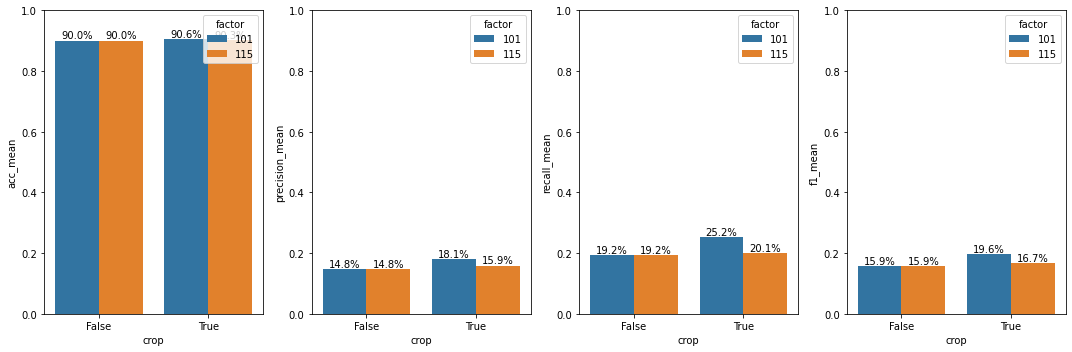

In [21]:
import matplotlib.ticker as plticker

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
ax = sns.barplot(x="crop", y="acc_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)
        

plt.subplot(1, 4, 2)
ax = sns.barplot(x="crop", y="precision_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 3)
ax = sns.barplot(x="crop", y="recall_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 4)
ax = sns.barplot(x="crop", y="f1_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.tight_layout()
plt.show()

Observando a figura, pode-se perceber que independente dos extratores ou fator de crop, o valor de acurácia é relativamente alto ao comparado com as demais métricas. Esse fato dá-se devido a quantidade de labels da classe negativa (a classe marjoritária), visto que temos um total de 59 unidades de ação e em média 3,14 unidades de ação em cada frame (ground truth). Portanto o classificador identifica de maneira correta grande parte dos true negativos, mas não necessariamente identifica de maneira os true positivos. Desta maneira, como a proporção de true negativo é muito maior que a dos true positivos, o valor de acurácia acaba não sendo uma métrica ideal para avaliar esse problema, necessitando explorar outras métricas, como precision, recall e f1-score.



### Impacto do Crop no MediaPipe

In [22]:
dg.loc[dg.extractor == 'mediapipe']

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
4,mediapipe,False,0,0.900183,0.147829,0.192422,0.158506
5,mediapipe,True,0,0.897138,0.178718,0.255947,0.198233
6,mediapipe,True,0025,0.896986,0.179890,0.271609,0.204134
7,mediapipe,True,005,0.896123,0.172854,0.272598,0.199951


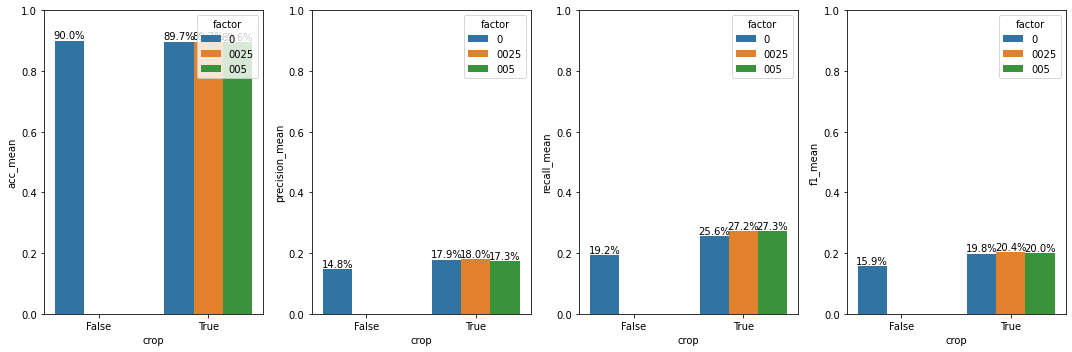

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
ax = sns.barplot(x="crop", y="acc_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 2)
ax = sns.barplot(x="crop", y="precision_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 3)
ax = sns.barplot(x="crop", y="recall_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 4)
ax = sns.barplot(x="crop", y="f1_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.tight_layout()
plt.show()

### Há diferença significativa entre os experimentos? 

In [24]:
data_stats = pd.pivot(df[['experiment', 'f1']].loc[df.var_mp != 'posicao'], values = 'f1', columns = 'experiment')
data_stats

experiment,dlib_crop_False_factor_101,dlib_crop_False_factor_115,dlib_crop_True_factor_101,dlib_crop_True_factor_115,mediapipe_id_crop_False_factor_0,mediapipe_id_crop_True_factor_0,mediapipe_id_crop_True_factor_0025,mediapipe_id_crop_True_factor_005
0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.4,0.5,0.0,0.0,0.0,0.0
3,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
663,0.4,0.4,0.4,0.0,0.4,0.0,0.0,0.0
664,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
665,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0


In [25]:
data_stats.columns

Index(['dlib_crop_False_factor_101', 'dlib_crop_False_factor_115',
       'dlib_crop_True_factor_101', 'dlib_crop_True_factor_115',
       'mediapipe_id_crop_False_factor_0', 'mediapipe_id_crop_True_factor_0',
       'mediapipe_id_crop_True_factor_0025',
       'mediapipe_id_crop_True_factor_005'],
      dtype='object', name='experiment')

In [26]:
data_stats = data_stats.rename(columns={
    'dlib_crop_False_factor_101': 'DF101', 
    'dlib_crop_False_factor_115': 'DF115',
    'dlib_crop_True_factor_101': 'DT101', 
    'dlib_crop_True_factor_115': 'DT115',
    'mediapipe_id_crop_False_factor_0' :'MF0', 
    'mediapipe_id_crop_True_factor_0': 'MT0',
    'mediapipe_id_crop_True_factor_0025': 'MT25',
    'mediapipe_id_crop_True_factor_005': 'MT50'
    
})

data_stats = data_stats[['DT115', 'DT101', 'DF101', 'DF115', 'MF0', 'MT0', 'MT25', 'MT50']]
data_stats

experiment,DT115,DT101,DF101,DF115,MF0,MT0,MT25,MT50
0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.4,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
663,0.0,0.4,0.4,0.4,0.4,0.0,0.0,0.0
664,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
data_stats = data_stats*100

In [28]:
data_stats.to_csv("../data/outputs/Videos-Emely-Extra/predicts_squeezenet/f1_estimation_stats.csv", sep=',', index=False)

#### Distribuição

array([[<AxesSubplot:title={'center':'DT115'}>,
        <AxesSubplot:title={'center':'DT101'}>,
        <AxesSubplot:title={'center':'DF101'}>],
       [<AxesSubplot:title={'center':'DF115'}>,
        <AxesSubplot:title={'center':'MF0'}>,
        <AxesSubplot:title={'center':'MT0'}>],
       [<AxesSubplot:title={'center':'MT25'}>,
        <AxesSubplot:title={'center':'MT50'}>, <AxesSubplot:>]],
      dtype=object)

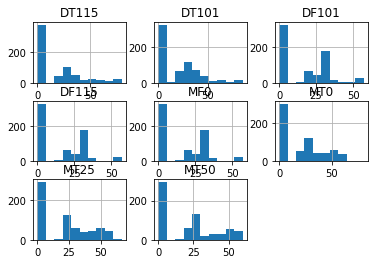

In [35]:
data_stats.hist()

<AxesSubplot:xlabel='DT101', ylabel='Count'>

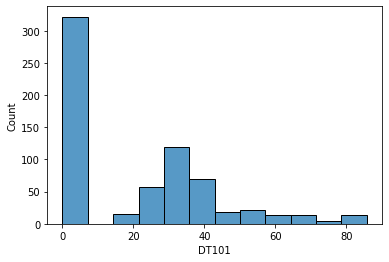

In [39]:
sns.histplot(data=data_stats, x="DT101")

In [ ]:
FIM

### Qual a abordagem que apresentou os melhores resutlados em comparação com a original?

In [29]:
df[['experiment', 'acc', 'precision', 'recall', 'f1']]

,experiment,acc,precision,recall,f1
0,dlib_crop_True_factor_101,0.949153,0.25,1.0,0.4
1,dlib_crop_True_factor_101,0.949153,0.25,1.0,0.4
2,dlib_crop_True_factor_101,0.949153,0.25,1.0,0.4
3,dlib_crop_True_factor_101,0.949153,0.25,1.0,0.4
4,dlib_crop_True_factor_101,0.949153,0.25,1.0,0.4
...,...,...,...,...,...
663,mediapipe_posicao_crop_True_factor_0025,0.898305,0.00,0.0,0.0
664,mediapipe_posicao_crop_True_factor_0025,0.898305,0.00,0.0,0.0
665,mediapipe_posicao_crop_True_factor_0025,0.898305,0.00,0.0,0.0
666,mediapipe_posicao_crop_True_factor_0025,0.898305,0.00,0.0,0.0


In [30]:
dg

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,False,101,0.900183,0.147829,0.192422,0.158506
1,dlib,False,115,0.900183,0.147829,0.192422,0.158506
2,dlib,True,101,0.906095,0.180963,0.251944,0.195797
3,dlib,True,115,0.903304,0.158583,0.201069,0.166791
4,mediapipe,False,0,0.900183,0.147829,0.192422,0.158506
5,mediapipe,True,0,0.897138,0.178718,0.255947,0.198233
6,mediapipe,True,0025,0.896986,0.179890,0.271609,0.204134
7,mediapipe,True,005,0.896123,0.172854,0.272598,0.199951


In [31]:
dg["experiment"] = dg["extractor"] +  dg["crop"] + dg["factor"].astype(str)
dg

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean,experiment
0,dlib,False,101,0.900183,0.147829,0.192422,0.158506,dlibFalse101
1,dlib,False,115,0.900183,0.147829,0.192422,0.158506,dlibFalse115
2,dlib,True,101,0.906095,0.180963,0.251944,0.195797,dlibTrue101
3,dlib,True,115,0.903304,0.158583,0.201069,0.166791,dlibTrue115
4,mediapipe,False,0,0.900183,0.147829,0.192422,0.158506,mediapipeFalse0
5,mediapipe,True,0,0.897138,0.178718,0.255947,0.198233,mediapipeTrue0
6,mediapipe,True,0025,0.896986,0.179890,0.271609,0.204134,mediapipeTrue0025
7,mediapipe,True,005,0.896123,0.172854,0.272598,0.199951,mediapipeTrue005


In [32]:
pip install Orange

  Using cached Orange-2.7.8.tar.gz (15.0 MB)
    ERROR: Command errored out with exit status 1:
     command: /bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1zmv8603/Orange/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1zmv8603/Orange/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-1zmv8603/Orange/pip-egg-info
         cwd: /tmp/pip-install-1zmv8603/Orange/
    Complete output (6 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-1zmv8603/Orange/setup.py", line 261
        except OSError, ex:
                      ^
    SyntaxError: invalid syntax
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
Note: you may nee

In [33]:
Control = dlibTrue115

NameError: name 'dlibTrue115' is not defined

In [ ]:
https://medium.com/@catur.supriyanto/how-to-visualize-the-nemenyi-and-bonferroni-dunn-diagrams-in-python-aa6a311f1cee

    

In [ ]:
import Orange 
import matplotlib.pyplot as plt
names = ["C4.5", "C4.5+m", "C4.5+cf", "C4.5+m+cf"]
avranks = [3.143,2.000,2.893,1.964]
cd = Orange.evaluation.compute_CD(avranks, 14,alpha="0.05", test="bonferroni-dunn") #tested on 14 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=5, textspace=1.5, cdmethod=0)
plt.show();

In [ ]:
dg.loc[dg.extractor == 'dlib'].plot(x='crop', 
        kind='bar',
        stacked=False, 
        title='Grouped Bar Graph with dataframe') 

In [ ]:

df = pd.DataFrame([['A', 10, 20, 10, 30], ['B', 20, 25, 15, 25], ['C', 12, 15, 19, 6], 
                   ['D', 10, 29, 13, 19]], 
                  columns=['Team', 'Round 1', 'Round 2', 'Round 3', 'Round 4']) 
print(df) 
df.plot(x='Team', 
        kind='bar', 
        stacked=False, 
        title='Grouped Bar Graph with dataframe') 

In [ ]:
ax = sns.barplot(x="factor", y="precision_mean", hue="crop", data=dg.loc[dg.extractor == 'mediapipe'])

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,1)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 2)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 3)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 4)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = sns.barplot(x="var_mp", y="acc_mean", hue='crop', data=dg.loc[dg.var_mp != 'Não se aplica'])
ax.bar_label(ax.containers[0])


In [ ]:
def plt_bar_extract_na(df_combined, na):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green', "red", 'blue']

    df = df_combined.loc[(df_combined['na'] == na)].reset_index()
    ax = sns.countplot(x="aug", hue="extractor", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title='Quantidade de frames com landmarks retornados (%)')
    idx_extractor=0
    for c in ax.containers:
        qt_extractores = len(df_combined.extractor.unique())
        qt_aug = len(df_combined.aug.unique())
        
        #labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        labels = [f'{w/((len(df_combined)/qt_extractores)/qt_aug)*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        idx_extractor=idx_extractor+1
        
    plt.xticks(rotation=20)
    
    
plt_bar_extract_na(df_combined,  0)

In [ ]:
FIM